# Fábrica de Chocolate

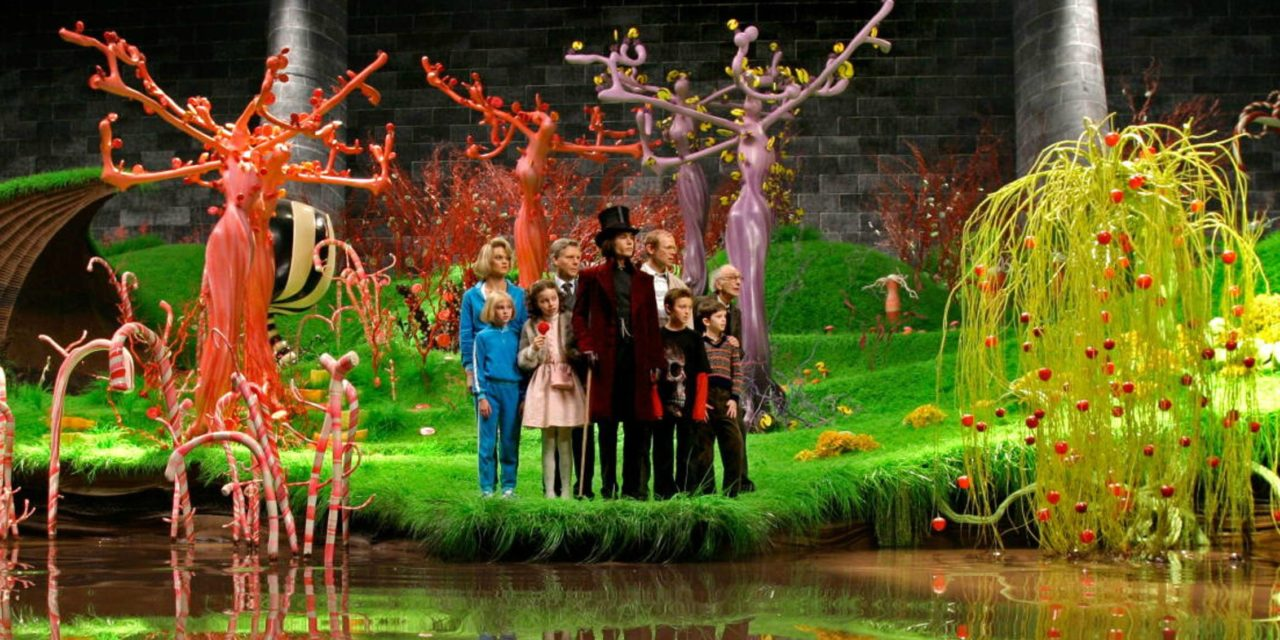

## Problema de negócio:

A fábrica "Compre Mais Chocolate" esta aumentando as suas vendas e por consequencia mudando de categoria. A fabrica que começou no quintal de uma casa produzindo bombom caseiro, hoje possui 45 funcionarios e possui um faturamento bruto médio mensal de R$120.000, vendendo em média 40.000 bombons.

Ela contratou um cientista de dados por ter visto um problema de negocio em relação ao peso de seus bombons, e lhe forneceu uma base de dados inchuta por ainda nao possuir uma cultura orientada a dados, o dataset fornecido possui variaveis como:
> QTD_CHOC: Quantidade de chocolate existente no bombom (com uma unidade de medida desconhecida).

> VAR_1: variavel numerica e de procedencia desconhecida

> VAR_2: variavel categorica e de procedencia desconhecida

> PESO_BOMBOM: Variavel Target (Valor em grama)

Sua função como Cientista de Dados da fábrica "Compre Mais Chocolate" é criar um modelo de inteligencia artificial que tente prever o peso do bombom, ao ser adicionada cada uma das 3 variaveis mencionadas. Todavia, seu modelo deve dar MAXIMA ATENÇÃO aos bombons que tenham peso inferior a 9g ou superior a 12g, o ideal é em torno de 10g cada bombom, porem caso seja inferior a 9g podem haver reclamaçoes dos clientes, e se superar 12g pode haver prejuizo por parte da empresa no que se refere a materia prima.

Boa Sorte!!

## Imports

In [1]:
!pip install xgboost

In [2]:
!pip install hyperopt

In [3]:
    #Ridge e Lasso
#shap values

import numpy as np
import pandas as pd 
import seaborn as sns
sns.color_palette()
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report
import functools
from hyperopt import hp, fmin, Trials, tpe
warnings.filterwarnings('ignore')
%matplotlib inline
import pickle 

class color: # para formatar os prints
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [4]:
df = pd.read_csv(r'C:\Users\DaviMonteiroPaulelli\Box Sync\Desafio_Fabrica_de_Chocolate\registros-prod.csv', delimiter = ',')

In [5]:
df.head()

,QTD_CHOC,VAR_1,VAR_2,PESO_BOMBOM
0,320.15,0.88,A,10.144919
1,320.14,1.55,A,11.547027
2,284.85,2.97,A,11.112109
3,263.92,2.36,C,9.900123
4,276.22,2.98,C,10.079822


In [6]:
df.dtypes

QTD_CHOC       float64
VAR_1          float64
VAR_2           object
PESO_BOMBOM    float64
dtype: object

## Transformando a variável 2 categórica em numérica

In [7]:
def trat_var2 (dado):
    if dado == 'A':
        return 1
    elif dado == 'B':
        return 2
    else:
        return 3

In [8]:
df_tratado = pd.DataFrame()
df_tratado[['PESO_BOMBOM', 'VAR_1', 'QTD_CHOC']] = df[['PESO_BOMBOM', 'VAR_1', 'QTD_CHOC']]
df_tratado['VAR_2'] = df['VAR_2'].apply(trat_var2)
df_tratado.head()

,PESO_BOMBOM,VAR_1,QTD_CHOC,VAR_2
0,10.144919,0.88,320.15,1
1,11.547027,1.55,320.14,1
2,11.112109,2.97,284.85,1
3,9.900123,2.36,263.92,3
4,10.079822,2.98,276.22,3


In [9]:
df_tratado.dtypes

PESO_BOMBOM    float64
VAR_1          float64
QTD_CHOC       float64
VAR_2            int64
dtype: object

## Normalizando as colunas e separando-as em treino e teste

In [10]:
# selecionando apenas variáveis independentes
X = df_tratado.drop('PESO_BOMBOM', axis=1)
# selecionando apenas a variável dependente(target)
y = df_tratado['PESO_BOMBOM']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=12)# serve para tornar o processo em algo reprodutivo

# vendo o shape de cada um dos x(linhas e colunas)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((350, 3), (150, 3), (350,), (150,))

## Alterando a escala das variáveis Treino e Teste

In [11]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<br>

# Funções dos gráficos

## Gráfico de 150 amostras reais, para analisar os picos (Positivos e Negativos)

In [12]:
def vl_reais( teste,                
              teste_label, 
              title_label, 
              x_label, 
              y_label):
    """"Plota um gráfico de linhas com dados de previsão e de teste. 
    Args:
          previsao(Series): Serie com os dados de previsão.
          teste(Series): Serie com os dados de teste.
          previsao_label(str): Nome do label da previsão na legenda.
          teste_label(str): Nome do label de teste na legenda.
          title_label(str): título do gráfico.
          x_label(str): Nome do label do eixo X.
          y_label(str): Nome do label do eixo Y.
    """
    # Determina o estilo
    plt.style.use('bmh')
    # Determina a cor de fundo do gráfico
    plt.rcParams['axes.facecolor'] = 'white'    
    # Determina o tamanho do gráfico.
    plt.figure(figsize=(11,6), dpi=100)
    #Plota o título
    plt.title(title_label, fontsize=15, fontdict={'family': 'serif','color' : 'black','weight': 'bold'})
    # Determina a espessura da linha 
    plt.rcParams['lines.linewidth'] = 2
    #lista de estilos de linha
    #http://matplotlib.org/1.5.3/api/pyplot_api.html#matplotlib.pyplot.plot
    #Plota a linha com o teste , cor pode ser substituída por hexadecimal - exemplo: #845ec2
    plt.plot(teste, label=teste_label, color = '#0000CD', linestyle ='--')
    #Plota a linha com a previsão , estilos de linha suportados : 'solid', 'dashed', 'dashdot', 'dotted'
 
    # Determina o tamanho das letras.(loc em geral upper left/ upper right)
    plt.legend(loc="upper right",fontsize=12)
    #Plota o label do eixo x próximo da origem (x=0 , máximo x=1)
    plt.xlabel(x_label,fontsize=14, horizontalalignment='left', x=0)
    #Plota o label do eixo y próximo da origem (y=0 , máximo y=1)
    plt.ylabel(y_label,fontsize=14, horizontalalignment='left', y=0)
    #seta a base do gráfico com 0
    plt.ylim(ymin=0)  
    plt.tight_layout()
    #Mostra o gráfico
    plt.show()

## Gráfico com o total de amostras (150)

In [13]:
def line_plot_total(previsao, 
              teste, 
              previsao_label, 
              teste_label, 
              title_label, 
              x_label, 
              y_label):
    """"Plota um gráfico de linhas com dados de previsão e de teste. 
    Args:
          previsao(Series): Serie com os dados de previsão.
          teste(Series): Serie com os dados de teste.
          previsao_label(str): Nome do label da previsão na legenda.
          teste_label(str): Nome do label de teste na legenda.
          title_label(str): título do gráfico.
          x_label(str): Nome do label do eixo X.
          y_label(str): Nome do label do eixo Y.
    """
    # Determina o estilo
    plt.style.use('bmh')
    # Determina a cor de fundo do gráfico
    plt.rcParams['axes.facecolor'] = 'white'    
    # Determina o tamanho do gráfico.
    plt.figure(figsize=(8,6), dpi=100)
    #Plota o título
    plt.title(title_label, fontsize=15, fontdict={'family': 'serif','color' : 'black','weight': 'bold'})
    # Determina a espessura da linha 
    plt.rcParams['lines.linewidth'] = 2
    plt.plot(previsao, label=previsao_label, color = '#00BFFF' , linestyle = 'solid')
    plt.rcParams['lines.linewidth'] = 1
    #lista de estilos de linha
    #http://matplotlib.org/1.5.3/api/pyplot_api.html#matplotlib.pyplot.plot
    #Plota a linha com o teste , cor pode ser substituída por hexadecimal - exemplo: #845ec2
    plt.plot(teste, label=teste_label, color = '#483D8B', linestyle ='--')
    #Plota a linha com a previsão , estilos de linha suportados : 'solid', 'dashed', 'dashdot', 'dotted'
 
    # Determina o tamanho das letras.(loc em geral upper left/ upper right)
    plt.legend(loc="upper right",fontsize=12)
    #Plota o label do eixo x próximo da origem (x=0 , máximo x=1)
    plt.xlabel(x_label,fontsize=14, horizontalalignment='left', x=0)
    #Plota o label do eixo y próximo da origem (y=0 , máximo y=1)
    plt.ylabel(y_label,fontsize=14, horizontalalignment='left', y=0)
    #seta a base do gráfico com 0
    plt.ylim(ymin=0)  
    #Mostra o gráfico
    plt.show()

## Gráfico com um zoom nas amostras (50)

In [14]:
def line_plot_aprox(previsao, 
              teste, 
              previsao_label, 
              teste_label, 
              title_label, 
              x_label, 
              y_label):
    """"Plota um gráfico de linhas com dados de previsão e de teste. 
    Args:
          previsao(Series): Serie com os dados de previsão.
          teste(Series): Serie com os dados de teste.
          previsao_label(str): Nome do label da previsão na legenda.
          teste_label(str): Nome do label de teste na legenda.
          title_label(str): título do gráfico.
          x_label(str): Nome do label do eixo X.
          y_label(str): Nome do label do eixo Y.
    """
    # Determina o estilo
    plt.style.use('bmh')
    # Determina a cor de fundo do gráfico
    plt.rcParams['axes.facecolor'] = 'white'    
    # Determina o tamanho do gráfico.
    plt.figure(figsize=(8,6), dpi=100)
    #Plota o título 
    plt.title(title_label, fontsize=15, fontdict={'family': 'serif','color' : 'black','weight': 'bold'})
    
    #lista de estilos de linha
    #http://matplotlib.org/1.5.3/api/pyplot_api.html#matplotlib.pyplot.plot
    #Plota a linha com a previsão , cor pode ser substituída por hexadecimal - exemplo: #845ec2
    plt.plot(previsao, label=previsao_label, color = '#00BFFF' , linestyle = 'solid')
    # Determina a espessura da linha
    plt.rcParams['lines.linewidth'] = 1
    
    plt.plot(teste, label=teste_label, color = '#483D8B', linestyle ='--')
    #Plota a linha com o teste , estilos de linha suportados : 'solid', 'dashed', 'dashdot', 'dotted'
    plt.rcParams['lines.linewidth'] = 2
   
    
    # Determina o tamanho das letras.(loc em geral upper left/ upper right)
    plt.legend(loc="lower right",fontsize=12)
    #Plota o label do eixo x próximo da origem (x=0 , máximo x=1)
    plt.xlabel(x_label,fontsize=14, horizontalalignment='left', x=0)
    #Plota o label do eixo y próximo da origem (y=0 , máximo y=1)
    plt.ylabel(y_label,fontsize=14, horizontalalignment='left', y=0)
    #seta a base do gráfico com 0
    plt.ylim(ymin=0)  
    #Mostra o gráfico
    plt.show()

<br>

## Arrumando os índices da variável 'y_test'

In [15]:
y_test = pd.Series(np.array(y_test))

## Analisando os picos abaixo de 9g e acima de 12g

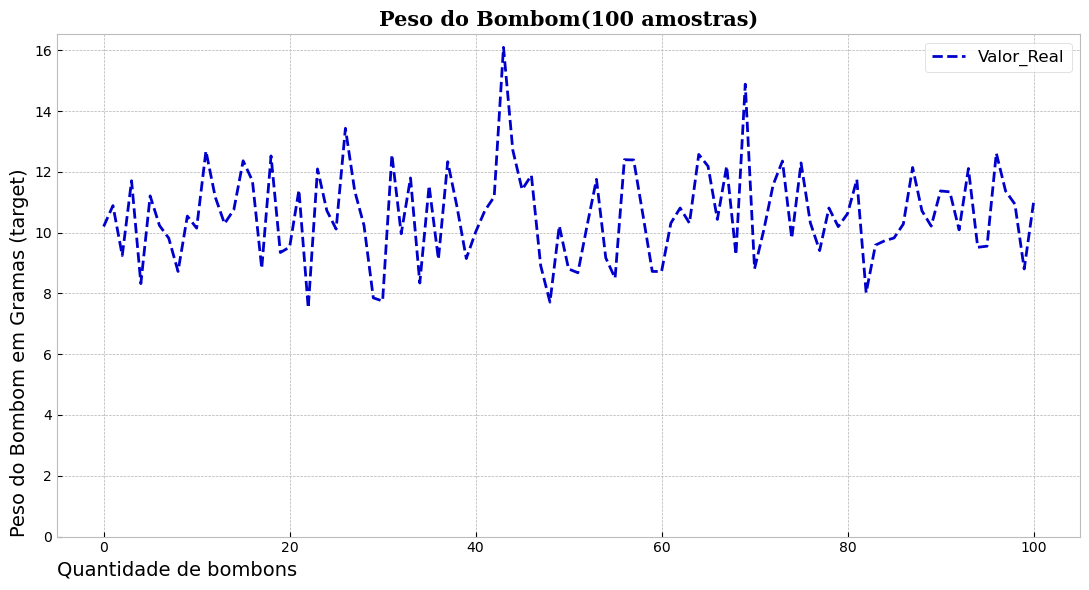

In [16]:
vl_reais(y_test[0:101],'Valor_Real','Peso do Bombom(100 amostras)','Quantidade de bombons','Peso do Bombom em Gramas (target)')

# Modelos de regressão

<br>

## 1°) KNN Regressor

In [17]:
model_KNN = KNeighborsRegressor()

In [18]:
model_KNN.fit(X_train,y_train)

KNeighborsRegressor()

In [19]:
y_pred_KNN = model_KNN.predict(X_test)

In [20]:
print(mean_squared_error(y_test,y_pred_KNN))

0.6959996380160526


In [21]:
print(mean_squared_error(y_test,y_pred_KNN, squared = False))

0.834265927637017


In [22]:
print(mean_absolute_error(y_test,y_pred_KNN))

0.4834547096733335


## Matriz de Confusão - KNN Regressor < 9g

In [23]:
cutoff = 9.0                                      # decide on a cutoff limit
y_pred_classes_KNN = np.zeros_like(y_pred_KNN)    # initialise a matrix full with zeros
y_pred_classes_KNN[y_pred_KNN < cutoff] = 1       # add a 1 if the cutoff was breached

In [24]:
y_test_classes_KNN = np.zeros_like(y_pred_KNN)
y_test_classes_KNN[y_test < cutoff] = 1

In [25]:
confusion_matrix(y_test_classes_KNN,y_pred_classes_KNN)
#superior esquerdo -> Verdadeiros Negativos, valores acima de 9(inversos a métrica), que foram identifados corretamente
#superior direito -> Falsos Positivos, que me retornam os valores acima de 9 que ele identificou como abaixo de 9
#inferior esquerdo -> Falsos Negativos, que me retornam a quantidade de valores abaixo de 9 que o modelo preditivo não identificou
#inferior direito -> Verdadeiros Positivos, que me retornam os valores abaixo de 9 que foram identificados no modelo

array([[125,   0],
       [  7,  18]], dtype=int64)

In [26]:
print(classification_report(y_test_classes_KNN,y_pred_classes_KNN, target_names=['Oposto', 'Target']))

              precision    recall  f1-score   support

      Oposto       0.95      1.00      0.97       125
      Target       1.00      0.72      0.84        25

    accuracy                           0.95       150
   macro avg       0.97      0.86      0.90       150
weighted avg       0.96      0.95      0.95       150



## Matriz de Confusão - KNN Regressor > 12g

In [27]:
cutoff2 = 12.0                                      # decide on a cutoff limit
y_pred_classes_KNN2 = np.zeros_like(y_pred_KNN)     # initialise a matrix full with zeros
y_pred_classes_KNN2[y_pred_KNN > cutoff2] = 1       # add a 1 if the cutoff was breached

In [28]:
y_test_classes_KNN2 = np.zeros_like(y_pred_KNN)
y_test_classes_KNN2[y_test > cutoff2] = 1

In [29]:
confusion_matrix(y_test_classes_KNN2,y_pred_classes_KNN2)
#superior esquerdo -> Verdadeiros Negativos, valores acima de 9(inversos a métrica), que foram identifados corretamente
#superior direito -> Falsos Positivos, que me retornam os valores acima de 9 que ele identificou como abaixo de 9
#inferior esquerdo -> Falsos Negativos, que me retornam a quantidade de valores abaixo de 9 que o modelo preditivo não identificou
#inferior direito -> Verdadeiros Positivos, que me retornam os valores abaixo de 9 que foram identificados no modelo

array([[122,   2],
       [  7,  19]], dtype=int64)

In [30]:
print(classification_report(y_test_classes_KNN2,y_pred_classes_KNN2, target_names=['Oposto', 'Target']))

              precision    recall  f1-score   support

      Oposto       0.95      0.98      0.96       124
      Target       0.90      0.73      0.81        26

    accuracy                           0.94       150
   macro avg       0.93      0.86      0.89       150
weighted avg       0.94      0.94      0.94       150



## Gráficos - KNN Regressor

In [31]:
y_pred_series_KNN = pd.Series(y_pred_KNN)
y_test_series_KNN = pd.Series(np.array(y_test))
type(y_pred_series_KNN), type(y_test_series_KNN)

(pandas.core.series.Series, pandas.core.series.Series)

In [32]:
#test_lista_KN_9 = []
#for value in y_test:
#    if value < 9:
#        test_lista_KN_9.append(value)
#        
#test_convert_KN_9 = list(test_lista_KN_9)
#len(test_convert_KN_9)

In [33]:
#pred_lista_KN_9 = []
#for value in y_pred_KNN:
#    if value < 9:
#        pred_lista_KN_9.append(value)
#
#pred_convert_KN_9 = list(pred_lista_KN_9)
#len(pred_convert_KN_9)

In [34]:
#test_lista_KN_12 = []
#for value in y_test:
#    if value > 12:
#        test_lista_KN_12.append(value)
#
#test_convert_KN_12 = list(test_lista_KN_12)
#len(test_convert_KN_12)

In [35]:
#pred_lista_KN_12 = []
#for value in y_pred_KNN:
#    if value > 12:
#        pred_lista_KN_12.append(value)
#
#pred_convert_KN_12 = list(pred_lista_KN_12)
#len(pred_convert_KN_12)

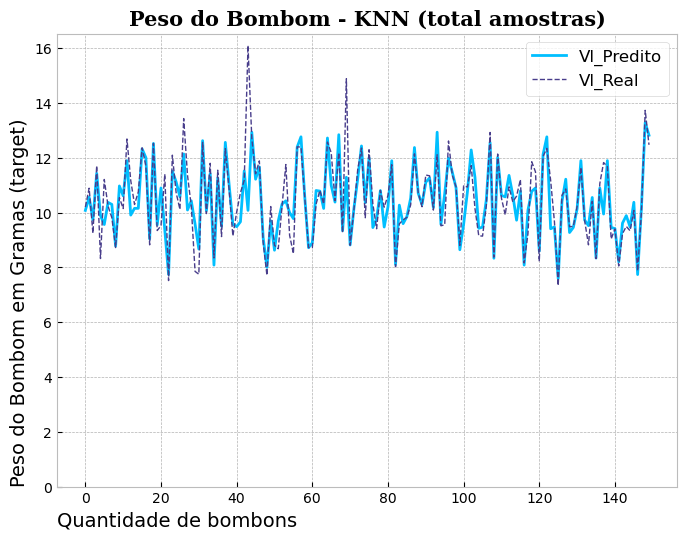

In [36]:
#print(color.BOLD)
#print('_'*45)
#print('Registros reais abaixo de 9g: {} amostras;'.format(len(test_convert_KN_9)))
#print('Registros preditos abaixo de 9g: {} amostras.'.format(len(pred_convert_KN_9)))
#print('_'*45)
#print('Registros reais acima de 12g: {} amostras;'.format(len(test_convert_KN_12)))
#print('Registros preditos acima de 12g: {} amostras.'.format(len(pred_convert_KN_12)))
#print('_'*45)
#print(color.END)

line_plot_total(y_pred_series_KNN,y_test_series_KNN,'Vl_Predito','Vl_Real','Peso do Bombom - KNN (total amostras)','Quantidade de bombons','Peso do Bombom em Gramas (target)')

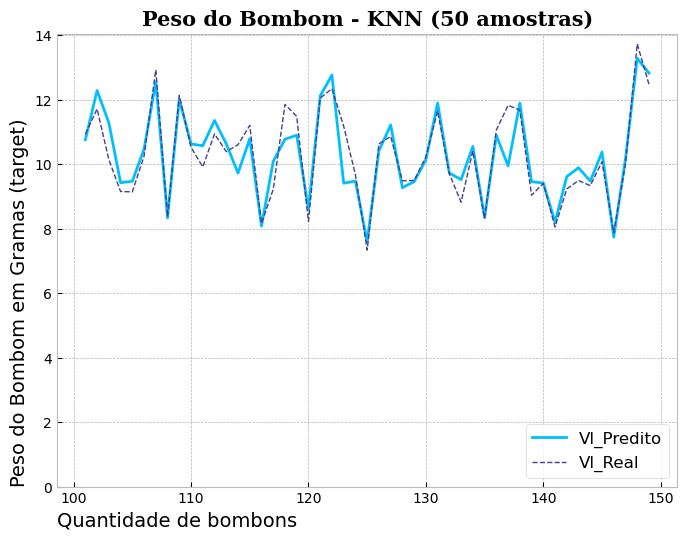

In [37]:
line_plot_aprox(y_pred_series_KNN[101:],y_test_series_KNN[101:],'Vl_Predito','Vl_Real','Peso do Bombom - KNN (50 amostras)','Quantidade de bombons','Peso do Bombom em Gramas (target)')

<br>

## 2°) Random Forest Regressor - Melhor que o Tunado

In [38]:
model2 = RandomForestRegressor(random_state=1)

In [39]:
model2.fit(X_train,y_train)

RandomForestRegressor(random_state=1)

In [40]:
y_pred = model2.predict(X_test)

In [41]:
print(mean_squared_error(y_test,y_pred))

1.116025987025336


In [42]:
print(mean_absolute_error(y_test,y_pred))

0.6101601581567995


## Matriz de Confusão - Random Forest Regressor < 9g

In [43]:
cutoff = 9.0                                 # decide on a cutoff limit
y_pred_classes_RF = np.zeros_like(y_pred)    # initialise a matrix full with zeros
y_pred_classes_RF[y_pred < cutoff] = 1       # add a 1 if the cutoff was breached

In [44]:
y_test_classes_RF = np.zeros_like(y_test)
y_test_classes_RF[y_test < cutoff] = 1

In [45]:
confusion_matrix(y_test_classes_RF,y_pred_classes_RF)
#superior esquerdo -> Verdadeiros Negativos, valores acima de 9(inversos a métrica), que foram identifados corretamente
#superior direito -> Falsos Positivos, que me retornam os valores acima de 9 que ele identificou como abaixo de 9
#inferior esquerdo -> Falsos Negativos, que me retornam a quantidade de valores abaixo de 9 que o modelo preditivo não identificou
#inferior direito -> Verdadeiros Positivos, que me retornam os valores abaixo de 9 que foram identificados no modelo

array([[124,   1],
       [ 12,  13]], dtype=int64)

In [46]:
print(classification_report(y_test_classes_RF,y_pred_classes_RF, target_names=['Não Descartado', 'Descartado']))

                precision    recall  f1-score   support

Não Descartado       0.91      0.99      0.95       125
    Descartado       0.93      0.52      0.67        25

      accuracy                           0.91       150
     macro avg       0.92      0.76      0.81       150
  weighted avg       0.91      0.91      0.90       150



## Matriz de Confusão - Random Forest Regressor > 12g

In [47]:
cutoff2 = 12.0                                      # decide on a cutoff limit
y_pred_classes_RF2 = np.zeros_like(y_pred)     # initialise a matrix full with zeros
y_pred_classes_RF2[y_pred > cutoff2] = 1       # add a 1 if the cutoff was breached

In [48]:
y_test_classes_RF2 = np.zeros_like(y_test)
y_test_classes_RF2[y_test > cutoff2] = 1

In [49]:
confusion_matrix(y_test_classes_RF2,y_pred_classes_RF2)
#superior esquerdo -> Verdadeiros Negativos, valores acima de 9(inversos a métrica), que foram identifados corretamente
#superior direito -> Falsos Positivos, que me retornam os valores acima de 12 que ele identificou como abaixo de 12
#inferior esquerdo -> Falsos Negativos, que me retornam a quantidade de valores abaixo de 9 que o modelo preditivo não identificou
#inferior direito -> Verdadeiros Positivos, que me retornam os valores abaixo de 9 que foram identificados no modelo

array([[123,   1],
       [  5,  21]], dtype=int64)

In [50]:
print(classification_report(y_test_classes_RF2,y_pred_classes_RF2, target_names=['Oposto', 'Target']))

              precision    recall  f1-score   support

      Oposto       0.96      0.99      0.98       124
      Target       0.95      0.81      0.88        26

    accuracy                           0.96       150
   macro avg       0.96      0.90      0.93       150
weighted avg       0.96      0.96      0.96       150



# Gráficos Random Forest Regressor

In [51]:
y_pred_series = pd.Series(y_pred)
y_test_series = pd.Series(np.array(y_test))
type(y_pred_series), type(y_test_series)

(pandas.core.series.Series, pandas.core.series.Series)

In [52]:
#test_lista_RF_9 = []
#for value in y_test:
#    if value < 9:
#        test_lista_RF_9.append(value)
#
#test_convert_RF_9 = list(test_lista_RF_9)
#len(test_convert_RF_9)

In [53]:
#pred_lista_RF_9 = []
#for value in y_pred:
#    if value < 9:
#        pred_lista_RF_9.append(value)
#
#pred_convert_RF_9 = list(pred_lista_RF_9)
#len(pred_convert_RF_9)

In [54]:
#test_lista_RF_12 = []
#for value in y_test:
#    if value > 12:
#        test_lista_RF_12.append(value)
#        
#test_convert_RF_12 = list(test_lista_RF_12)
#len(test_convert_RF_12)

In [55]:
#pred_lista_RF_12 = []
#for value in y_pred:
#    if value > 12:
#        pred_lista_RF_12.append(value)
#        
#pred_convert_RF_12 = list(pred_lista_RF_12)
#len(pred_convert_RF_12)

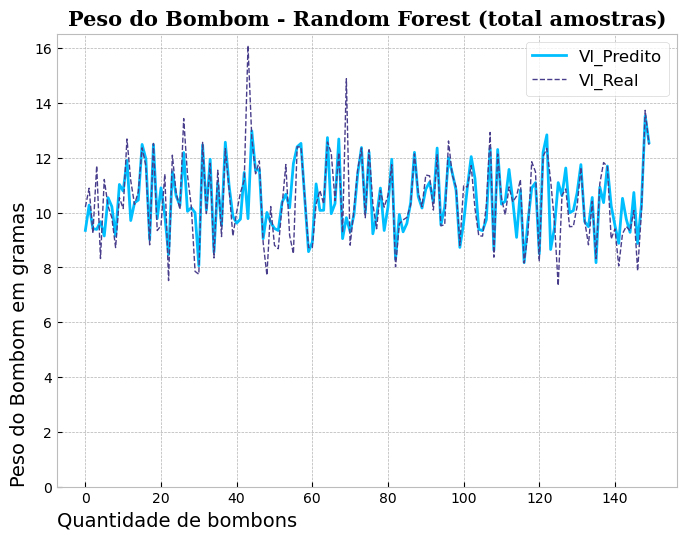

In [56]:
#print(color.BOLD)
#print('_'*45)
#print('Registros reais abaixo de 9g: {} amostras;'.format(len(test_convert_RF_9)))
#print('Registros preditos abaixo de 9g: {} amostras.'.format(len(pred_convert_RF_9)))
#print('_'*45)
#print('Registros reais acima de 12g: {} amostras;'.format(len(test_convert_RF_12)))
#print('Registros preditos acima de 12g: {} amostras.'.format(len(pred_convert_RF_12)))
#print('_'*45)
#print(color.END)

line_plot_total(y_pred_series,y_test_series,'Vl_Predito','Vl_Real','Peso do Bombom - Random Forest (total amostras)','Quantidade de bombons','Peso do Bombom em gramas')

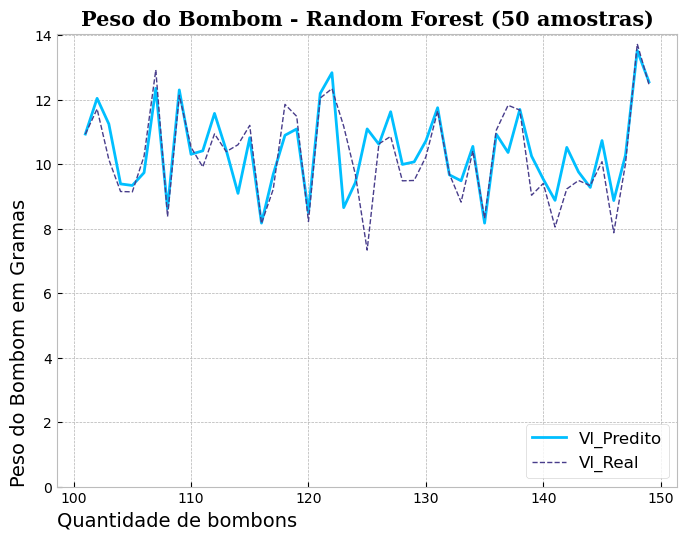

In [57]:
line_plot_aprox(y_pred_series[101:],y_test_series[101:],'Vl_Predito','Vl_Real','Peso do Bombom - Random Forest (50 amostras)','Quantidade de bombons','Peso do Bombom em Gramas')

<br>

## 3°) XGBoost Regressor - Melhor que o Tunado

In [58]:
model_xgb = XGBRegressor(random_state = 42)

In [59]:
model_xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
y_pred_xgb = model_xgb.predict(X_test)

In [61]:
print(mean_squared_error(y_test,y_pred_xgb))

1.274984310537443


In [62]:
print(mean_absolute_error(y_test,y_pred_xgb))

0.6814206211849838


## Matriz de Confusão - XGBoost Regressor < 9g

In [63]:
cutoff = 9.0                                 # decide on a cutoff limit
y_pred_classes_XG = np.zeros_like(y_pred_xgb)    # initialise a matrix full with zeros
y_pred_classes_XG[y_pred_xgb < cutoff] = 1       # add a 1 if the cutoff was breached

In [64]:
y_test_classes_XG = np.zeros_like(y_pred_xgb)
y_test_classes_XG[y_test < cutoff] = 1

In [65]:
confusion_matrix(y_test_classes_XG,y_pred_classes_XG)
#superior esquerdo -> Verdadeiros Negativos, valores acima de 9(inversos a métrica), que foram identifados corretamente
#superior direito -> Falsos Positivos, que me retornam os valores acima de 9 que ele identificou como abaixo de 9
#inferior esquerdo -> Falsos Negativos, que me retornam a quantidade de valores abaixo de 9 que o modelo preditivo não identificou
#inferior direito -> Verdadeiros Positivos, que me retornam os valores abaixo de 9 que foram identificados no modelo

array([[120,   5],
       [ 10,  15]], dtype=int64)

In [66]:
print(classification_report(y_test_classes_XG,y_pred_classes_XG, target_names=['Oposto', 'Target']))

              precision    recall  f1-score   support

      Oposto       0.92      0.96      0.94       125
      Target       0.75      0.60      0.67        25

    accuracy                           0.90       150
   macro avg       0.84      0.78      0.80       150
weighted avg       0.89      0.90      0.90       150



## Matriz de Confusão - XGBoost Regressor > 12g

In [67]:
cutoff2 = 12.0                                      # decide on a cutoff limit
y_pred_classes_XG2 = np.zeros_like(y_pred_xgb)     # initialise a matrix full with zeros
y_pred_classes_XG2[y_pred_xgb > cutoff2] = 1       # add a 1 if the cutoff was breached

In [68]:
y_test_classes_XG2 = np.zeros_like(y_test)
y_test_classes_XG2[y_test > cutoff2] = 1

In [69]:
confusion_matrix(y_test_classes_XG2,y_pred_classes_XG2)
#superior esquerdo -> Verdadeiros Negativos, valores acima de 9(inversos a métrica), que foram identifados corretamente
#superior direito -> Falsos Positivos, que me retornam os valores acima de 12 que ele identificou como abaixo de 12
#inferior esquerdo -> Falsos Negativos, que me retornam a quantidade de valores abaixo de 9 que o modelo preditivo não identificou
#inferior direito -> Verdadeiros Positivos, que me retornam os valores abaixo de 9 que foram identificados no modelo

array([[117,   7],
       [  5,  21]], dtype=int64)

In [70]:
print(classification_report(y_test_classes_XG2,y_pred_classes_XG2, target_names=['Oposto', 'Target']))

              precision    recall  f1-score   support

      Oposto       0.96      0.94      0.95       124
      Target       0.75      0.81      0.78        26

    accuracy                           0.92       150
   macro avg       0.85      0.88      0.86       150
weighted avg       0.92      0.92      0.92       150



## Gráficos XGBoost Regressor 

In [71]:
y_pred_series_xgb = pd.Series(y_pred_xgb)
y_test_series_xgb = pd.Series(np.array(y_test))
type(y_pred_series_xgb), type(y_test_series_xgb)

(pandas.core.series.Series, pandas.core.series.Series)

In [72]:
#test_lista_XG_9 = []
#for value in y_test:
#    if value < 9:
#        test_lista_XG_9.append(value)
#        
#test_convert_XG_9 = list(test_lista_XG_9)
#len(test_convert_XG_9)

In [73]:
#pred_lista_XG_9 = []
#for value in y_pred_xgb:
#    if value < 9:
#        pred_lista_XG_9.append(value)
#
#pred_convert_XG_9 = list(pred_lista_XG_9)
#len(pred_convert_XG_9)

In [74]:
#test_lista_XG_12 = []
#for value in y_test:
#    if value > 12:
#        test_lista_XG_12.append(value)
#
#test_convert_XG_12 = list(test_lista_XG_12)
#len(test_convert_XG_12)

In [75]:
#pred_lista_XG_12 = []
#for value in y_pred_xgb:
#    if value > 12:
#        pred_lista_XG_12.append(value)
#
#pred_convert_XG_12 = list(pred_lista_XG_12)
#len(pred_convert_XG_12)

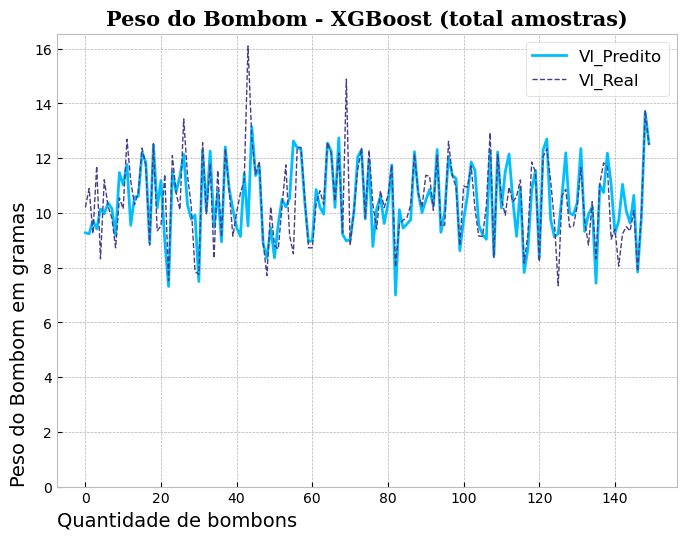

In [76]:
#print(color.BOLD)
#print('_'*45)
#print('Registros reais abaixo de 9g: {} amostras;'.format(len(test_convert_XG_9)))
#print('Registros preditos abaixo de 9g: 15 amostras.')#.format(len(pred_convert_XG_9)))
#print('_'*45)
#print('Registros reais acima de 12g: {} amostras;'.format(len(test_convert_XG_12)))
#print('Registros preditos acima de 12g: {} amostras.'.format(len(pred_convert_XG_12)))
#print('_'*45)
#print(color.END)

line_plot_total(y_pred_series_xgb,y_test_series_xgb,'Vl_Predito','Vl_Real','Peso do Bombom - XGBoost (total amostras)','Quantidade de bombons','Peso do Bombom em gramas')

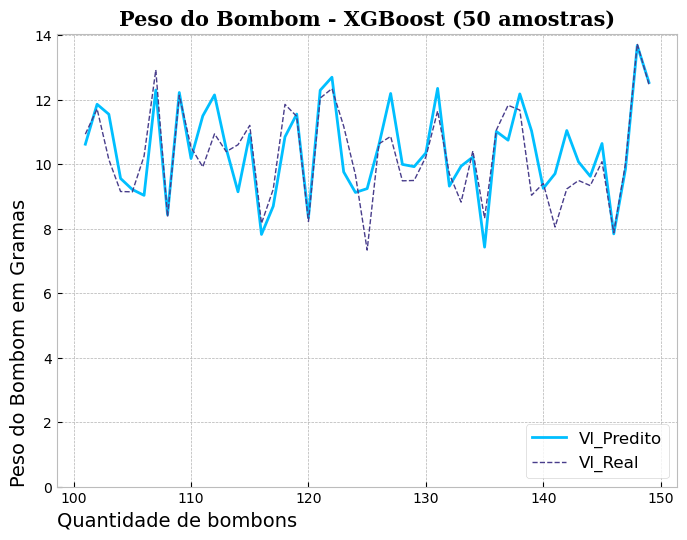

In [77]:
line_plot_aprox(y_pred_series_xgb[101:],y_test_series_xgb[101:],'Vl_Predito','Vl_Real','Peso do Bombom - XGBoost (50 amostras)','Quantidade de bombons','Peso do Bombom em Gramas')

<br>

<br>

## 4°) SVM Regressor

In [78]:
model_svm = SVR(kernel = 'linear')

In [79]:
model_svm.fit(X_train,y_train)

SVR(kernel='linear')

In [80]:
y_pred_svm = model_svm.predict(X_test)

In [81]:
print(mean_squared_error(y_test,y_pred_svm))

1.6996019970115304


In [82]:
print(mean_squared_error(y_test, y_pred_svm , squared=False))

1.3036878449274314


In [83]:
print(mean_absolute_error(y_test,y_pred_svm))

0.8141438833868586


## Matriz de Confusão - SVM Regressor > 12g

In [84]:
cutoff2 = 12.0                                      # decide on a cutoff limit
y_pred_classes_SV2 = np.zeros_like(y_pred_svm)     # initialise a matrix full with zeros
y_pred_classes_SV2[y_pred_svm > cutoff2] = 1       # add a 1 if the cutoff was breached

In [85]:
y_test_classes_SV2 = np.zeros_like(y_test)
y_test_classes_SV2[y_test > cutoff2] = 1

In [86]:
confusion_matrix(y_test_classes_SV2,y_pred_classes_SV2)
#superior esquerdo -> Verdadeiros Negativos, valores acima de 9(inversos a métrica), que foram identifados corretamente
#superior direito -> Falsos Positivos, que me retornam os valores acima de 12 que ele identificou como abaixo de 12
#inferior esquerdo -> Falsos Negativos, que me retornam a quantidade de valores abaixo de 9 que o modelo preditivo não identificou
#inferior direito -> Verdadeiros Positivos, que me retornam os valores abaixo de 9 que foram identificados no modelo

array([[123,   1],
       [ 17,   9]], dtype=int64)

In [87]:
print(classification_report(y_test_classes_SV2,y_pred_classes_SV2, target_names=['Oposto', 'Target']))

              precision    recall  f1-score   support

      Oposto       0.88      0.99      0.93       124
      Target       0.90      0.35      0.50        26

    accuracy                           0.88       150
   macro avg       0.89      0.67      0.72       150
weighted avg       0.88      0.88      0.86       150



## Matriz de Confusão - SVM Regressor < 9g

In [88]:
cutoff = 9.0                                 # decide on a cutoff limit
y_pred_classes_SV = np.zeros_like(y_pred_svm)    # initialise a matrix full with zeros
y_pred_classes_SV[y_pred_svm < cutoff] = 1       # add a 1 if the cutoff was breached

In [89]:
y_test_classes_SV = np.zeros_like(y_pred_svm)
y_test_classes_SV[y_test < cutoff] = 1

In [90]:
confusion_matrix(y_test_classes_SV,y_pred_classes_SV)
#superior esquerdo -> Verdadeiros Negativos, valores acima de 9(inversos a métrica), que foram identifados corretamente
#superior direito -> Falsos Positivos, que me retornam os valores acima de 9 que ele identificou como abaixo de 9
#inferior esquerdo -> Falsos Negativos, que me retornam a quantidade de valores abaixo de 9 que o modelo preditivo não identificou
#inferior direito -> Verdadeiros Positivos, que me retornam os valores abaixo de 9 que foram identificados no modelo

array([[113,  12],
       [ 15,  10]], dtype=int64)

In [91]:
print(classification_report(y_test_classes_SV,y_pred_classes_SV, target_names=['Oposto', 'Target']))

              precision    recall  f1-score   support

      Oposto       0.88      0.90      0.89       125
      Target       0.45      0.40      0.43        25

    accuracy                           0.82       150
   macro avg       0.67      0.65      0.66       150
weighted avg       0.81      0.82      0.82       150



## Gráficos SVM Regressor

In [92]:
y_pred_series = pd.Series(y_pred_svm)
y_test_series = pd.Series(np.array(y_test))
type(y_pred_series), type(y_test_series)

(pandas.core.series.Series, pandas.core.series.Series)

In [93]:
#test_lista_SV_9 = []
#for value in y_test:
#    if value < 9:
#        test_lista_SV_9.append(value)
#        
#test_convert_SV_9 = list(test_lista_SV_9)
#len(test_convert_SV_9)

In [94]:
#pred_lista_SV_9 = []
#for value in y_pred_svm:
#    if value < 9:
#        pred_lista_SV_9.append(value)
#
#pred_convert_SV_9 = list(pred_lista_SV_9)
#len(pred_convert_SV_9)

In [95]:
#test_lista_SV_12 = []
#for value in y_test:
#    if value > 12:
#        test_lista_SV_12.append(value)
#
#test_convert_SV_12 = list(test_lista_SV_12)
#len(test_convert_SV_12)

In [96]:
#pred_lista_SV_12 = []
#for value in y_pred_svm:
#    if value > 12:
#        pred_lista_SV_12.append(value)
#
#pred_convert_SV_12 = list(pred_lista_SV_12)
#len(pred_convert_SV_12)

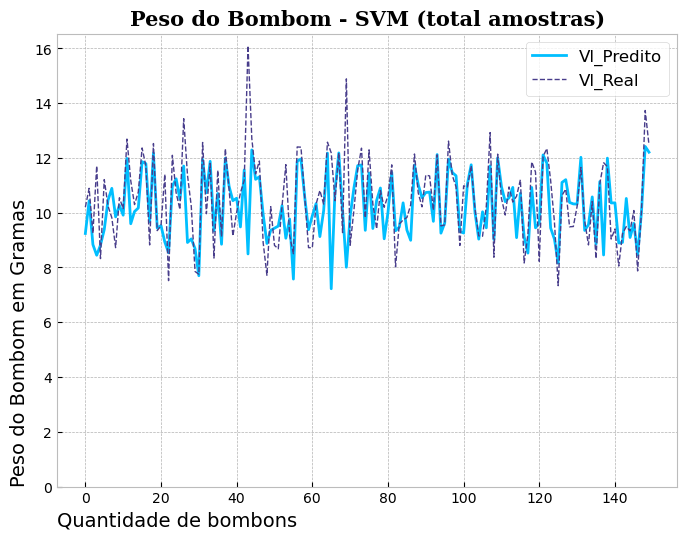

In [97]:
#print(color.BOLD)
#print('_'*45)
#print('Registros reais abaixo de 9g: {} amostras;'.format(len(test_convert_SV_9)))
#print('Registros preditos abaixo de 9g: {} amostras.'.format(len(pred_convert_SV_9)))
#print('_'*45)
#print('Registros reais acima de 12g: {} amostras;'.format(len(test_convert_SV_12)))
#print('Registros preditos acima de 12g: {} amostras.'.format(len(pred_convert_SV_12)))
#print('_'*45)
#print(color.END)

line_plot_total(y_pred_series,y_test_series,'Vl_Predito','Vl_Real','Peso do Bombom - SVM (total amostras)','Quantidade de bombons','Peso do Bombom em Gramas')

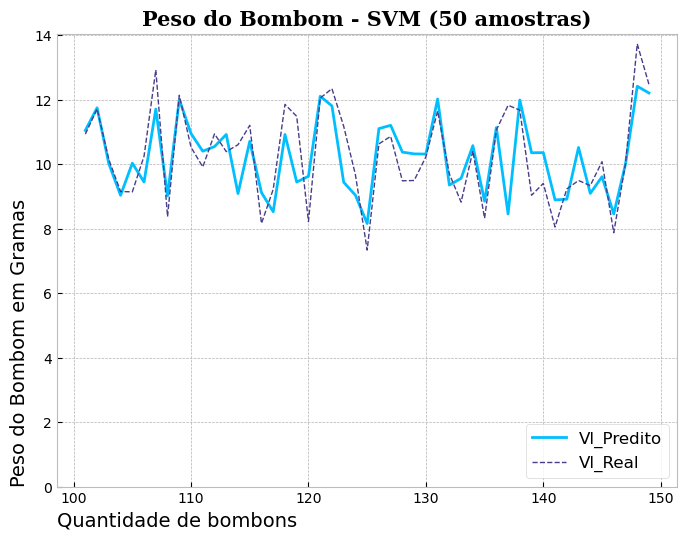

In [98]:
line_plot_aprox(y_pred_series[101:],y_test_series[101:],'Vl_Predito','Vl_Real','Peso do Bombom - SVM (50 amostras)','Quantidade de bombons','Peso do Bombom em Gramas')

<br>

## 5°) Regressão Linear Sklearn

In [99]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [100]:
y_pred_reg = model.predict(X_test)

In [101]:
# a média do erro quadrado pred, deu uma média de erro relativamente alta, por conta desta métrica penalizar outliers e
# ser melhor na predição dos valores centrais, por levar muito em conta a linha de regressão
print(mean_squared_error(y_test,y_pred_reg))

1.5198356518896667


In [102]:
print(mean_absolute_error(y_test,y_pred_reg))

0.8289202544744042


## Matriz de Confusão - SVM Regressor < 9g

In [103]:
cutoff = 9.0                                 # decide on a cutoff limit
y_pred_classes_RL = np.zeros_like(y_pred_reg)    # initialise a matrix full with zeros
y_pred_classes_RL[y_pred_reg < cutoff] = 1       # add a 1 if the cutoff was breached

In [104]:
y_test_classes_RL = np.zeros_like(y_pred_reg)
y_test_classes_RL[y_test < cutoff] = 1

In [105]:
confusion_matrix(y_test_classes_RL,y_pred_classes_RL)
#superior esquerdo -> Verdadeiros Negativos, valores acima de 9(inversos a métrica), que foram identifados corretamente
#superior direito -> Falsos Positivos, que me retornam os valores acima de 9 que ele identificou como abaixo de 9
#inferior esquerdo -> Falsos Negativos, que me retornam a quantidade de valores abaixo de 9 que o modelo preditivo não identificou
#inferior direito -> Verdadeiros Positivos, que me retornam os valores abaixo de 9 que foram identificados no modelo

array([[123,   2],
       [ 22,   3]], dtype=int64)

In [106]:
print(classification_report(y_test_classes_RL,y_pred_classes_RL, target_names=['Oposto', 'Target']))

              precision    recall  f1-score   support

      Oposto       0.85      0.98      0.91       125
      Target       0.60      0.12      0.20        25

    accuracy                           0.84       150
   macro avg       0.72      0.55      0.56       150
weighted avg       0.81      0.84      0.79       150



## Matriz de Confusão - SVM Regressor > 12g

In [107]:
cutoff2 = 12.0                                      # decide on a cutoff limit
y_pred_classes_RL2 = np.zeros_like(y_pred_reg)     # initialise a matrix full with zeros
y_pred_classes_RL2[y_pred_reg > cutoff2] = 1       # add a 1 if the cutoff was breached

In [108]:
y_test_classes_RL2 = np.zeros_like(y_test)
y_test_classes_RL2[y_test > cutoff2] = 1

In [109]:
confusion_matrix(y_test_classes_SV2,y_pred_classes_SV2)
#superior esquerdo -> Verdadeiros Negativos, valores acima de 9(inversos a métrica), que foram identifados corretamente
#superior direito -> Falsos Positivos, que me retornam os valores acima de 12 que ele identificou como abaixo de 12
#inferior esquerdo -> Falsos Negativos, que me retornam a quantidade de valores abaixo de 9 que o modelo preditivo não identificou
#inferior direito -> Verdadeiros Positivos, que me retornam os valores abaixo de 9 que foram identificados no modelo

array([[123,   1],
       [ 17,   9]], dtype=int64)

In [110]:
print(classification_report(y_test_classes_RL2,y_pred_classes_RL2, target_names=['Oposto', 'Target']))

              precision    recall  f1-score   support

      Oposto       0.84      1.00      0.91       124
      Target       1.00      0.08      0.14        26

    accuracy                           0.84       150
   macro avg       0.92      0.54      0.53       150
weighted avg       0.87      0.84      0.78       150



## Gráficos - Regressão Linear

In [111]:
y_pred_series = pd.Series(y_pred)
y_test_series = pd.Series(np.array(y_test))
type(y_pred_series), type(y_test_series)

(pandas.core.series.Series, pandas.core.series.Series)

In [112]:
#test_lista_RL_9 = []
#for value in y_test:
#    if value < 9:
#        test_lista_RL_9.append(value)
#        
#test_convert_RL_9 = list(test_lista_RL_9)
#len(test_convert_RL_9)

In [113]:
#pred_lista_RL_9 = []
#for value in y_pred_reg:
#    if value < 9:
#        pred_lista_RL_9.append(value)
#
#pred_convert_RL_9 = list(pred_lista_RL_9)
#len(pred_convert_RL_9)

In [114]:
#test_lista_RL_12 = []
#for value in y_test:
#    if value > 12:
#        test_lista_RL_12.append(value)
#
#test_convert_RL_12 = list(test_lista_RL_12)
#len(test_convert_RL_12)

In [115]:
#pred_lista_RL_12 = []
#for value in y_pred_reg:
#    if value > 12:
#        pred_lista_RL_12.append(value)
#
#pred_convert_RL_12 = list(pred_lista_RL_12)
#len(pred_convert_RL_12)

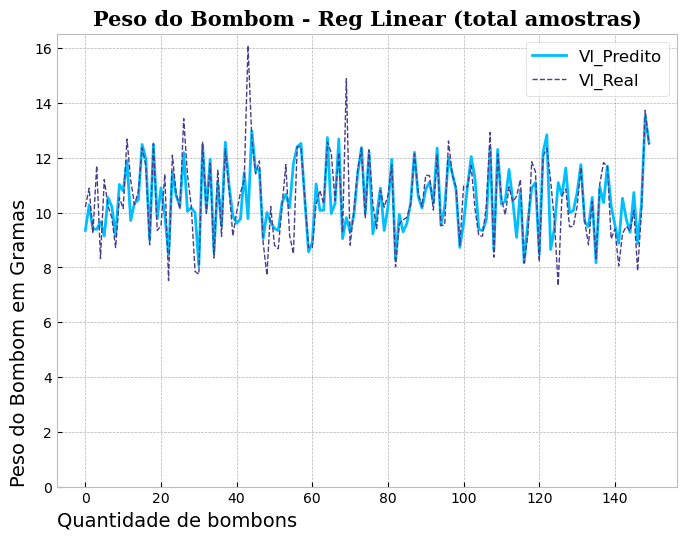

In [116]:
#print(color.BOLD)
#print('_'*45)
#print('Registros reais abaixo de 9g: {} amostras;'.format(len(test_convert_RL_9)))
#print('Registros preditos abaixo de 9g: {} amostras.'.format(len(pred_convert_RL_9)))
#print('_'*45)
#print('Registros reais acima de 12g: {} amostras;'.format(len(test_convert_RL_12)))
#print('Registros preditos acima de 12g: {} amostras.'.format(len(pred_convert_RL_12)))
#print('_'*45)
#print(color.END)

line_plot_total(y_pred_series,y_test_series,'Vl_Predito','Vl_Real','Peso do Bombom - Reg Linear (total amostras)','Quantidade de bombons','Peso do Bombom em Gramas')

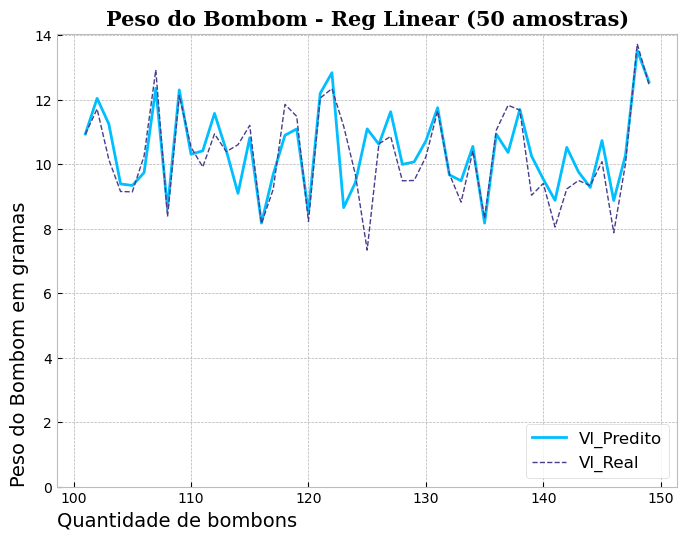

In [117]:
line_plot_aprox(y_pred_series[101:],y_test_series[101:],'Vl_Predito','Vl_Real','Peso do Bombom - Reg Linear (50 amostras)','Quantidade de bombons','Peso do Bombom em gramas')

<br>

# Tunning e Cross Validation

## KNN Regressor Tunning - Encontrando o Melhor K para o modelo

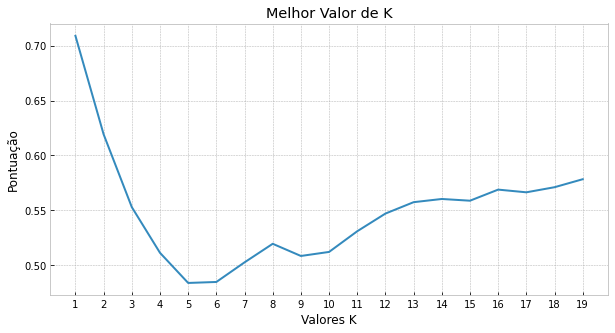

In [118]:
# Lista Pontuação 
scoreList = []
    
# Range de K 
for i in range(1,20):
    knn2 = KNeighborsRegressor(n_neighbors=i)
    knn2.fit(X_train, y_train)
    y_pred_knntn = knn2.predict(X_test)
    mae_knn = mean_absolute_error(y_test, y_pred_knntn)
    scoreList.append(mae_knn)

# Gráfico Valores K 
plt.figure(figsize=(10,5))
plt.plot(range(1,20), scoreList)
plt.xticks(np.arange(1,20,1))
plt.ylabel('Pontuação')
plt.xlabel('Valores K')
plt.title('Melhor Valor de K')
plt.show()

## Cross Validation - KFold - KNN --> 1° Lugar

In [119]:
print(color.BOLD)
kf_knn = KFold(n_splits=5, shuffle=True, random_state=42) # como tenho poucas amostras, 5 dobras já é o suficiente

# Resultados cross validation do modelo preditivo
rmse_results = []
mse_results = []
mae_results = []
# matriz de confusão < 9g
acc_results = []
pre_results = []
rec_results = []
f1_results = []
# matriz de confusão > 12g
acc_results2 = []
pre_results2 = []
rec_results2 = []
f1_results2 = []

cutoff = 9.0
cutoff2 = 12.0
fold = 0
print('<<< KNN Regressor >>>')
print('\n\n')
for train_index, test_index in kf_knn.split(X):
    fold += 1
    
    print('_'*23)
    print('Fold: ', fold)
    print('Treino: ',train_index.shape[0])
    print('Teste: ', test_index.shape[0])
        # separando os dados 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
    
    scaler = StandardScaler() ###É MUITO IMPORTANTE UTILIZÁ-LO, POIS O ESCALONAMENTO DOS DADOS É EXCENCIAL PARA O RESULTADO###

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
   
    ### Por conta dos modelos do xgboost e do random forest serem baseados em árvore(if e else), a diferença não foi muito grande,porém
    ### com o knn é diferente, ele leva em conta a distância euclidiana, a normalização da escala dos dados é muito mais importante

    model_KNN = KNeighborsRegressor(n_neighbors=8)
    model_KNN.fit(X_train,y_train)
    y_pred_CV_knn = model_KNN.predict(X_test)
    ###################<9g#######################
    y_test_classes_KNN = np.zeros_like(y_test)
    y_test_classes_KNN[y_test < cutoff] = 1
    
    y_pred_classes_KNN = np.zeros_like(y_pred_CV_knn)    
    y_pred_classes_KNN[y_pred_CV_knn < cutoff] = 1 
    #############################################
    
    ###################>12g#######################
    y_test_classes_KNN2 = np.zeros_like(y_pred_CV_knn)
    y_test_classes_KNN2[y_test > cutoff2] = 1 
    
    y_pred_classes_KNN2 = np.zeros_like(y_pred_CV_knn)    
    y_pred_classes_KNN2[y_pred_CV_knn > cutoff2] = 1
    ##############################################
    mse = mean_squared_error(y_test,y_pred_CV_knn)
    rmse = mean_squared_error(y_test, y_pred_CV_knn , squared=False)
    mae = mean_absolute_error(y_test,y_pred_CV_knn)
    ####################<9g########################
    acc = accuracy_score(y_test_classes_KNN, y_pred_classes_KNN)
    rec = recall_score(y_test_classes_KNN,y_pred_classes_KNN)
    pre = precision_score(y_test_classes_KNN,y_pred_classes_KNN)
    f1  = f1_score(y_test_classes_KNN,y_pred_classes_KNN)
    ####################>12g#######################
    acc2 = accuracy_score(y_test_classes_KNN2, y_pred_classes_KNN2)
    rec2 = recall_score(y_test_classes_KNN2,y_pred_classes_KNN2)
    pre2 = precision_score(y_test_classes_KNN2,y_pred_classes_KNN2)
    f12  = f1_score(y_test_classes_KNN2,y_pred_classes_KNN2)
    
    mse_results.append(mse)
    rmse_results.append(rmse)
    mae_results.append(mae)
    
    acc_results.append(acc)
    pre_results.append(pre)
    rec_results.append(rec)
    f1_results.append(f1)
    
    acc_results2.append(acc2)
    pre_results2.append(pre2)
    rec_results2.append(rec2)
    f1_results2.append(f12) 
    
    print('-'*23)
    print('Cross Validation:')
    print('RMSE: {}'.format(rmse))
    print('MSE: {}'.format(mse))
    print('MAE: {}'.format(mae))
    print('-'*23)
    print('Matriz de confusão > 12g')
    print('ACC: {}'.format(acc2))
    print('PRE: {}'.format(pre2))
    print('REC: {}'.format(rec2))
    print('F1: {}'.format(f12))
    print('-'*23)
    print('Matriz de confusão < 9g')
    print('ACC: {}'.format(acc))
    print('PRE: {}'.format(pre))
    print('REC: {}'.format(rec))
    print('F1: {}'.format(f1))
    print('_'*23)
    print('\n')


print('_'*54)
print('Cross-Validation:')
print('-> RMSE (Root Mean Squared Error): {};'.format(np.mean(rmse_results))) # Erro médio quadrado na raiz(colocando esta métrica na mesma da nossa target)    
print('-> MSE (Mean Squared Error): {};'.format(np.mean(mse_results))) # Erro médio quadrado (penaliza outliers)
print('-> MAE (Mean Absolute Error): {}.'.format(np.mean(mae_results))) # Erro médio absoluto (não penaliza outliers)
print('_'*54)

print('Matriz de confusão > 12g:')
print('-> ACC (Accuracy Score): {};'.format(np.mean(acc_results2))) # O quão efetivo foi o modelo para identificar os valores abaixo de 9, ou seja, a porcentagem de dados que de fato são da classe  
print('-> PRE (Precision Score): {};'.format(np.mean(pre_results2))) # Mostra a diferença entre as classes, se o modelo está entendendo bem quando o valor é 0 ou 1  
print('-> REC (Recall Score): {};'.format(np.mean(rec_results2))) # A porcentagem de dados que realmente estão abaixo de 9g e o modelo preveu
print('-> F1 (F1 Score): {}.'.format(np.mean(f1_results2))) # Média ponderada entre a precisão e o recall
print('_'*54)

print('Matriz de confusão < 9g:')
print('-> ACC (Accuracy Score): {};'.format(np.mean(acc_results))) # O quão efetivo foi o modelo para identificar os valores abaixo de 9, ou seja, a porcentagem de dados que de fato são da classe  
print('-> PRE (Precision Score): {};'.format(np.mean(pre_results))) # Mostra a diferença entre as classes, se o modelo está entendendo bem quando o valor é 0 ou 1  
print('-> REC (Recall Score): {};'.format(np.mean(rec_results))) # A porcentagem de dados que realmente estão abaixo de 9g e o modelo preveu
print('-> F1 (F1 Score): {}.'.format(np.mean(f1_results))) # Média ponderada entre a precisão e o recall
                                                                    
print('_'*54)


<<< KNN Regressor >>>



_______________________
Fold:  1
Treino:  400
Teste:  100
-----------------------
Cross Validation:
RMSE: 1.0060954122860777
MSE: 1.0122279786230928
MAE: 0.5871473693587501
-----------------------
Matriz de confusão > 12g
ACC: 0.97
PRE: 0.9166666666666666
REC: 0.8461538461538461
F1: 0.8799999999999999
-----------------------
Matriz de confusão < 9g
ACC: 0.91
PRE: 1.0
REC: 0.5263157894736842
F1: 0.6896551724137931
_______________________


_______________________
Fold:  2
Treino:  400
Teste:  100
-----------------------
Cross Validation:
RMSE: 1.2498261723776747
MSE: 1.5620654611602292
MAE: 0.6391564455650001
-----------------------
Matriz de confusão > 12g
ACC: 0.91
PRE: 0.6666666666666666
REC: 0.6153846153846154
F1: 0.64
-----------------------
Matriz de confusão < 9g
ACC: 0.92
PRE: 0.9
REC: 0.5625
F1: 0.6923076923076923
_______________________


_______________________
Fold:  3
Treino:  400
Teste:  100
-----------------------
Cross Validation:
RMSE: 0.864959

In [120]:
#salvar modelo
#filename = "KNN_CV.pkl"
#pickle.dump(model_KNN, open(filename, 'wb'))

<br>

## Cross Validation - KFold - Random Forest Regressor --> 2° Lugar

In [121]:
np.random.seed(42)

In [122]:
print(color.BOLD)
kf = KFold(n_splits=5, shuffle=True, random_state=42) # como tenho poucas amostras, 5 dobras já é o suficiente

# Resultados cross validation do modelo preditivo
rmse_results = []
mse_results = []
mae_results = []
# matriz de confusão < 9g
acc_results = []
pre_results = []
rec_results = []
f1_results = []
# matriz de confusão > 12g
acc_results2 = []
pre_results2 = []
rec_results2 = []
f1_results2 = []

cutoff2 = 12.0
cutoff = 9.0   
fold = 0
print('<<< Random Forest Regressor >>>')
print('\n\n')
for train_index, test_index in kf.split(X):
    fold += 1
    print('_'*23)
    print('Fold: ', fold)
    print('Treino: ',train_index.shape[0])
    print('Teste: ', test_index.shape[0])
        # separando os dados 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
    
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model2 = RandomForestRegressor(random_state=1)
    model2.fit(X_train,y_train)
    y_pred_CV = model2.predict(X_test)
    ###################<9g#######################
    y_test_classes_RF = np.zeros_like(y_test)
    y_test_classes_RF[y_test < cutoff] = 1
    
    y_pred_classes_RF = np.zeros_like(y_pred_CV)    
    y_pred_classes_RF[y_pred_CV < cutoff] = 1 
    #############################################
    
    ###################>12g#######################
    y_test_classes_RF2 = np.zeros_like(y_pred_CV)
    y_test_classes_RF2[y_test > cutoff2] = 1 
    
    y_pred_classes_RF2 = np.zeros_like(y_pred_CV)    
    y_pred_classes_RF2[y_pred_CV > cutoff2] = 1
    ##############################################
    mse = mean_squared_error(y_test,y_pred_CV)
    rmse = mean_squared_error(y_test, y_pred_CV , squared=False)
    mae = mean_absolute_error(y_test,y_pred_CV)
    ####################<9g########################
    acc = accuracy_score(y_test_classes_RF, y_pred_classes_RF)
    rec = recall_score(y_test_classes_RF,y_pred_classes_RF)
    pre = precision_score(y_test_classes_RF,y_pred_classes_RF)
    f1  = f1_score(y_test_classes_RF,y_pred_classes_RF)
    ####################<12g#######################
    acc2 = accuracy_score(y_test_classes_RF2, y_pred_classes_RF2)
    rec2 = recall_score(y_test_classes_RF2,y_pred_classes_RF2)
    pre2 = precision_score(y_test_classes_RF2,y_pred_classes_RF2)
    f12  = f1_score(y_test_classes_RF2,y_pred_classes_RF2)
    
    mse_results.append(mse)
    rmse_results.append(rmse)
    mae_results.append(mae)
    
    acc_results.append(acc)
    pre_results.append(pre)
    rec_results.append(rec)
    f1_results.append(f1)
    
    acc_results2.append(acc2)
    pre_results2.append(pre2)
    rec_results2.append(rec2)
    f1_results2.append(f12) 
    
    print('-'*23)
    print('Cross Validation:')
    print('RMSE: {}'.format(rmse))
    print('MSE: {}'.format(mse))
    print('MAE: {}'.format(mae))
    print('-'*23)
    print('Matriz de confusão > 12g')
    print('ACC: {}'.format(acc2))
    print('PRE: {}'.format(pre2))
    print('REC: {}'.format(rec2))
    print('F1: {}'.format(f12))
    print('-'*23)
    print('Matriz de confusão < 9g')
    print('ACC: {}'.format(acc))
    print('PRE: {}'.format(pre))
    print('REC: {}'.format(rec))
    print('F1: {}'.format(f1))
    print('_'*23)
    print('\n')

print('_'*54)
print('Cross-Validation:')
print('-> RMSE (Root Mean Squared Error): {};'.format(np.mean(rmse_results))) # Erro médio quadrado na raiz(colocando esta métrica na mesma da nossa target)    
print('-> MSE (Mean Squared Error): {};'.format(np.mean(mse_results))) # Erro médio quadrado (penaliza outliers)
print('-> MAE (Mean Absolute Error): {}.'.format(np.mean(mae_results))) # Erro médio absoluto (não penaliza outliers)
print('_'*54)

print('Matriz de confusão > 12g:')
print('-> ACC (Accuracy Score): {};'.format(np.mean(acc_results2))) # O quão efetivo foi o modelo para identificar os valores abaixo de 9, ou seja, a porcentagem de dados que de fato são da classe  
print('-> PRE (Precision Score): {};'.format(np.mean(pre_results2))) # Mostra a diferença entre as classes, se o modelo está entendendo bem quando o valor é 0 ou 1  
print('-> REC (Recall Score): {};'.format(np.mean(rec_results2))) # A porcentagem de dados que realmente estão abaixo de 9g e o modelo preveu
print('-> F1 (F1 Score): {}.'.format(np.mean(f1_results2))) # Média ponderada entre a precisão e o recall
print('_'*54)

print('Matriz de confusão < 9g:')
print('-> ACC (Accuracy Score): {};'.format(np.mean(acc_results))) # O quão efetivo foi o modelo para identificar os valores abaixo de 9, ou seja, a porcentagem de dados que de fato são da classe  
print('-> PRE (Precision Score): {};'.format(np.mean(pre_results))) # Mostra a diferença entre as classes, se o modelo está entendendo bem quando o valor é 0 ou 1  
print('-> REC (Recall Score): {};'.format(np.mean(rec_results))) # A porcentagem de dados que realmente estão abaixo de 9g e o modelo preveu
print('-> F1 (F1 Score): {}.'.format(np.mean(f1_results))) # Média ponderada entre a precisão e o recall
                                                                    
print('_'*54)


<<< Random Forest Regressor >>>



_______________________
Fold:  1
Treino:  400
Teste:  100
-----------------------
Cross Validation:
RMSE: 1.0834945567952539
MSE: 1.1739604546049436
MAE: 0.6419095164233005
-----------------------
Matriz de confusão > 12g
ACC: 0.98
PRE: 1.0
REC: 0.8461538461538461
F1: 0.9166666666666666
-----------------------
Matriz de confusão < 9g
ACC: 0.89
PRE: 0.8333333333333334
REC: 0.5263157894736842
F1: 0.6451612903225806
_______________________


_______________________
Fold:  2
Treino:  400
Teste:  100
-----------------------
Cross Validation:
RMSE: 1.3660229440622418
MSE: 1.8660186837044748
MAE: 0.7010913372413993
-----------------------
Matriz de confusão > 12g
ACC: 0.93
PRE: 0.75
REC: 0.6923076923076923
F1: 0.7199999999999999
-----------------------
Matriz de confusão < 9g
ACC: 0.88
PRE: 0.75
REC: 0.375
F1: 0.5
_______________________


_______________________
Fold:  3
Treino:  400
Teste:  100
-----------------------
Cross Validation:
RMSE: 0.78399293783

In [123]:
# salvar modelo #
#filename = "RNF_CV.pkl"
#pickle.dump(model2, open(filename, 'wb'))

<br>

## Cross Validation - KFold - XGBoost --> 3° Lugar

In [124]:
print(color.BOLD)
kf_xg = KFold(n_splits=5, shuffle=True, random_state=42) # como tenho poucas amostras, 5 dobras já é o suficiente

# Resultados cross validation do modelo preditivo
rmse_results = []
mse_results = []
mae_results = []
# matriz de confusão < 9g
acc_results = []
pre_results = []
rec_results = []
f1_results = []
# matriz de confusão > 12g
acc_results2 = []
pre_results2 = []
rec_results2 = []
f1_results2 = []

cutoff2 = 12.0
cutoff = 9.0
fold = 0
print('<<< XGBoost Regressor >>>')
print('\n\n')
for train_index, test_index in kf_xg.split(X):
    fold += 1
    print('_'*23)
    print('Fold: ', fold)
    print('Treino: ',train_index.shape[0])
    print('Teste: ', test_index.shape[0])
        # separando os dados 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
    
    scaler = StandardScaler()
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model_xgb = XGBRegressor(random_state = 42)
    model_xgb.fit(X_train,y_train)
    y_pred_CV_xgb = model_xgb.predict(X_test)
    ###################<9g#######################
    y_test_classes_XG = np.zeros_like(y_test)
    y_test_classes_XG[y_test < cutoff] = 1
    
    y_pred_classes_XG = np.zeros_like(y_pred_CV_xgb)    
    y_pred_classes_XG[y_pred_CV_xgb < cutoff] = 1 
    #############################################
    
    ###################>12g#######################
    y_test_classes_XG2 = np.zeros_like(y_pred_CV)
    y_test_classes_XG2[y_test > cutoff2] = 1 
    
    y_pred_classes_XG2 = np.zeros_like(y_pred_CV_xgb)    
    y_pred_classes_XG2[y_pred_CV_xgb > cutoff2] = 1
    ##############################################
    
    mse = mean_squared_error(y_test,y_pred_CV_xgb)
    rmse = mean_squared_error(y_test, y_pred_CV_xgb , squared=False)
    mae = mean_absolute_error(y_test,y_pred_CV_xgb)
    ####################<9g########################
    acc = accuracy_score(y_test_classes_XG, y_pred_classes_XG)
    rec = recall_score(y_test_classes_XG,y_pred_classes_XG)
    pre = precision_score(y_test_classes_XG,y_pred_classes_XG)
    f1  = f1_score(y_test_classes_XG,y_pred_classes_XG)
    ####################<12g#######################
    acc2 = accuracy_score(y_test_classes_RF2, y_pred_classes_RF2)
    rec2 = recall_score(y_test_classes_RF2,y_pred_classes_RF2)
    pre2 = precision_score(y_test_classes_RF2,y_pred_classes_RF2)
    f12  = f1_score(y_test_classes_RF2,y_pred_classes_RF2)
    
    mse_results.append(mse)
    rmse_results.append(rmse)
    mae_results.append(mae)
    
    acc_results.append(acc)
    pre_results.append(pre)
    rec_results.append(rec)
    f1_results.append(f1)
    
    acc_results2.append(acc2)
    pre_results2.append(pre2)
    rec_results2.append(rec2)
    f1_results2.append(f12) 
    
    print('-'*23)
    print('Cross Validation:')
    print('RMSE: {}'.format(rmse))
    print('MSE: {}'.format(mse))
    print('MAE: {}'.format(mae))
    print('-'*23)
    print('Matriz de confusão > 12g')
    print('ACC: {}'.format(acc2))
    print('PRE: {}'.format(pre2))
    print('REC: {}'.format(rec2))
    print('F1: {}'.format(f12))
    print('-'*23)
    print('Matriz de confusão < 9g')
    print('ACC: {}'.format(acc))
    print('PRE: {}'.format(pre))
    print('REC: {}'.format(rec))
    print('F1: {}'.format(f1))
    print('_'*23)
    print('\n')

print('_'*54)
print('Cross-Validation:')
print('-> RMSE (Root Mean Squared Error): {};'.format(np.mean(rmse_results))) # Erro médio quadrado na raiz(colocando esta métrica na mesma da nossa target)    
print('-> MSE (Mean Squared Error): {};'.format(np.mean(mse_results))) # Erro médio quadrado (penaliza outliers)
print('-> MAE (Mean Absolute Error): {}.'.format(np.mean(mae_results))) # Erro médio absoluto (não penaliza outliers)
print('_'*54)

print('Matriz de confusão > 12g:')
print('-> ACC (Accuracy Score): {};'.format(np.mean(acc_results2))) # O quão efetivo foi o modelo para identificar os valores abaixo de 9, ou seja, a porcentagem de dados que de fato são da classe  
print('-> PRE (Precision Score): {};'.format(np.mean(pre_results2))) # Mostra a diferença entre as classes, se o modelo está entendendo bem quando o valor é 0 ou 1  
print('-> REC (Recall Score): {};'.format(np.mean(rec_results2))) # A porcentagem de dados que realmente estão abaixo de 9g e o modelo preveu
print('-> F1 (F1 Score): {}.'.format(np.mean(f1_results2))) # Média ponderada entre a precisão e o recall
print('_'*54)

print('Matriz de confusão < 9g:')
print('-> ACC (Accuracy Score): {};'.format(np.mean(acc_results))) # O quão efetivo foi o modelo para identificar os valores abaixo de 9, ou seja, a porcentagem de dados que de fato são da classe  
print('-> PRE (Precision Score): {};'.format(np.mean(pre_results))) # Mostra a diferença entre as classes, se o modelo está entendendo bem quando o valor é 0 ou 1  
print('-> REC (Recall Score): {};'.format(np.mean(rec_results))) # A porcentagem de dados que realmente estão abaixo de 9g e o modelo preveu
print('-> F1 (F1 Score): {}.'.format(np.mean(f1_results))) # Média ponderada entre a precisão e o recall
                                                                    
print('_'*54)


<<< XGBoost Regressor >>>



_______________________
Fold:  1
Treino:  400
Teste:  100
-----------------------
Cross Validation:
RMSE: 1.1922497953088131
MSE: 1.421459574413907
MAE: 0.7155497538588014
-----------------------
Matriz de confusão > 12g
ACC: 0.92
PRE: 0.6923076923076923
REC: 0.6923076923076923
F1: 0.6923076923076923
-----------------------
Matriz de confusão < 9g
ACC: 0.85
PRE: 0.75
REC: 0.3157894736842105
F1: 0.44444444444444436
_______________________


_______________________
Fold:  2
Treino:  400
Teste:  100
-----------------------
Cross Validation:
RMSE: 1.3413990194506127
MSE: 1.7993513293830652
MAE: 0.7052612923949023
-----------------------
Matriz de confusão > 12g
ACC: 0.92
PRE: 0.6923076923076923
REC: 0.6923076923076923
F1: 0.6923076923076923
-----------------------
Matriz de confusão < 9g
ACC: 0.88
PRE: 0.75
REC: 0.375
F1: 0.5
_______________________


_______________________
Fold:  3
Treino:  400
Teste:  100
-----------------------
Cross Validation:
RMSE: 0.92

In [125]:
# salvar modelo #
#filename = "XGB_CV.pkl"
#pickle.dump(model_xgb, open(filename, 'wb'))

## Cross Validation - KFold - SVM --> 4° Lugar

In [126]:
print(color.BOLD)
kf_knn = KFold(n_splits=5, shuffle=True, random_state=42) # como tenho poucas amostras, 5 dobras já é o suficiente

# Resultados cross validation do modelo preditivo
rmse_results = []
mse_results = []
mae_results = []
# matriz de confusão < 9g
acc_results = []
pre_results = []
rec_results = []
f1_results = []
# matriz de confusão > 12g
acc_results2 = []
pre_results2 = []
rec_results2 = []
f1_results2 = []

cutoff = 9.0
cutoff2 = 12.0
fold = 0
print('<<< SVM Regressor >>>')
print('\n\n')
for train_index, test_index in kf_knn.split(X):
    fold += 1
    
    print('_'*23)
    print('Fold: ', fold)
    print('Treino: ',train_index.shape[0])
    print('Teste: ', test_index.shape[0])
        # separando os dados 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
    
    scaler = StandardScaler() ###É MUITO IMPORTANTE UTILIZÁ-LO, POIS O ESCALONAMENTO DOS DADOS É EXCENCIAL PARA O RESULTADO###

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
   
    ### Por conta dos modelos do xgboost e do random forest serem baseados em árvore(if e else), a diferença não foi muito grande,porém
    ### com o knn é diferente, ele leva em conta a distância euclidiana, a normalização da escala dos dados é muito mais importante

    model_svm = model_svm = SVR(kernel = 'linear')
    model_svm.fit(X_train,y_train)
    y_pred_cv_svm = model_svm.predict(X_test)
    ###################<9g#######################
    y_test_classes_SV = np.zeros_like(y_test)
    y_test_classes_SV[y_test < cutoff] = 1
    
    y_pred_classes_SV = np.zeros_like(y_pred_cv_svm)    
    y_pred_classes_SV[y_pred_cv_svm < cutoff] = 1 
    #############################################
    
    ###################>12g#######################
    y_test_classes_SV2 = np.zeros_like(y_pred_cv_svm)
    y_test_classes_SV2[y_test > cutoff2] = 1 
    
    y_pred_classes_SV2 = np.zeros_like(y_pred_cv_svm)    
    y_pred_classes_SV2[y_pred_cv_svm > cutoff2] = 1
    ##############################################
    mse = mean_squared_error(y_test,y_pred_cv_svm)
    rmse = mean_squared_error(y_test, y_pred_cv_svm , squared=False)
    mae = mean_absolute_error(y_test,y_pred_cv_svm)
    ####################<9g########################
    acc = accuracy_score(y_test_classes_SV, y_pred_classes_SV)
    rec = recall_score(y_test_classes_SV,y_pred_classes_SV)
    pre = precision_score(y_test_classes_SV,y_pred_classes_SV)
    f1  = f1_score(y_test_classes_SV,y_pred_classes_SV)
    ####################>12g#######################
    acc2 = accuracy_score(y_test_classes_SV2, y_pred_classes_SV2)
    rec2 = recall_score(y_test_classes_SV2,y_pred_classes_SV2)
    pre2 = precision_score(y_test_classes_SV2,y_pred_classes_SV2)
    f12  = f1_score(y_test_classes_SV2,y_pred_classes_SV2)
    
    mse_results.append(mse)
    rmse_results.append(rmse)
    mae_results.append(mae)
    
    acc_results.append(acc)
    pre_results.append(pre)
    rec_results.append(rec)
    f1_results.append(f1)
    
    acc_results2.append(acc2)
    pre_results2.append(pre2)
    rec_results2.append(rec2)
    f1_results2.append(f12) 
    
    print('-'*23)
    print('Cross Validation:')
    print('RMSE: {}'.format(rmse))
    print('MSE: {}'.format(mse))
    print('MAE: {}'.format(mae))
    print('-'*23)
    print('Matriz de confusão > 12g')
    print('ACC: {}'.format(acc2))
    print('PRE: {}'.format(pre2))
    print('REC: {}'.format(rec2))
    print('F1: {}'.format(f12))
    print('-'*23)
    print('Matriz de confusão < 9g')
    print('ACC: {}'.format(acc))
    print('PRE: {}'.format(pre))
    print('REC: {}'.format(rec))
    print('F1: {}'.format(f1))
    print('_'*23)
    print('\n')


print('_'*54)
print('Cross-Validation:')
print('-> RMSE (Root Mean Squared Error): {};'.format(np.mean(rmse_results))) # Erro médio quadrado na raiz(colocando esta métrica na mesma da nossa target)    
print('-> MSE (Mean Squared Error): {};'.format(np.mean(mse_results))) # Erro médio quadrado (penaliza outliers)
print('-> MAE (Mean Absolute Error): {}.'.format(np.mean(mae_results))) # Erro médio absoluto (não penaliza outliers)
print('_'*54)

print('Matriz de confusão > 12g:')
print('-> ACC (Accuracy Score): {};'.format(np.mean(acc_results2))) # O quão efetivo foi o modelo para identificar os valores abaixo de 9, ou seja, a porcentagem de dados que de fato são da classe  
print('-> PRE (Precision Score): {};'.format(np.mean(pre_results2))) # Mostra a diferença entre as classes, se o modelo está entendendo bem quando o valor é 0 ou 1  
print('-> REC (Recall Score): {};'.format(np.mean(rec_results2))) # A porcentagem de dados que realmente estão abaixo de 9g e o modelo preveu
print('-> F1 (F1 Score): {}.'.format(np.mean(f1_results2))) # Média ponderada entre a precisão e o recall
print('_'*54)

print('Matriz de confusão < 9g:')
print('-> ACC (Accuracy Score): {};'.format(np.mean(acc_results))) # O quão efetivo foi o modelo para identificar os valores abaixo de 9, ou seja, a porcentagem de dados que de fato são da classe  
print('-> PRE (Precision Score): {};'.format(np.mean(pre_results))) # Mostra a diferença entre as classes, se o modelo está entendendo bem quando o valor é 0 ou 1  
print('-> REC (Recall Score): {};'.format(np.mean(rec_results))) # A porcentagem de dados que realmente estão abaixo de 9g e o modelo preveu
print('-> F1 (F1 Score): {}.'.format(np.mean(f1_results))) # Média ponderada entre a precisão e o recall
                                                                    
print('_'*54)


<<< SVM Regressor >>>



_______________________
Fold:  1
Treino:  400
Teste:  100
-----------------------
Cross Validation:
RMSE: 1.3081035516873594
MSE: 1.7111349019370843
MAE: 0.8497046759258104
-----------------------
Matriz de confusão > 12g
ACC: 0.92
PRE: 0.8571428571428571
REC: 0.46153846153846156
F1: 0.6
-----------------------
Matriz de confusão < 9g
ACC: 0.8
PRE: 0.47368421052631576
REC: 0.47368421052631576
F1: 0.47368421052631576
_______________________


_______________________
Fold:  2
Treino:  400
Teste:  100
-----------------------
Cross Validation:
RMSE: 1.569241349665893
MSE: 2.4625184135012335
MAE: 0.8687997724051633
-----------------------
Matriz de confusão > 12g
ACC: 0.91
PRE: 0.8333333333333334
REC: 0.38461538461538464
F1: 0.5263157894736842
-----------------------
Matriz de confusão < 9g
ACC: 0.87
PRE: 0.5882352941176471
REC: 0.625
F1: 0.6060606060606061
_______________________


_______________________
Fold:  3
Treino:  400
Teste:  100
-----------------------
C

In [127]:
#salvar modelo
#filename = "SVM_CV.pkl"
#pickle.dump(model_svm, open(filename, 'wb'))

## Cross Validation - KFold - Regressão Linear --> 5° Lugar

In [128]:
print(color.BOLD)
kf_xg = KFold(n_splits=5, shuffle=True, random_state=42) # como tenho poucas amostras, 5 dobras já é o suficiente

mse_results = []
mae_results = []
acc_results = []
pre_results = []
rec_results = []
f1_results = []

cutoff = 9.0
fold = 0
print('<<< Linear Regression >>>')
print('\n\n')
for train_index, test_index in kf_xg.split(X):
    fold += 1
    print('_'*23)
    print('Fold: ', fold)
    print('Treino: ',train_index.shape[0])
    print('Teste: ', test_index.shape[0])
        # separando os dados 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
    
    scaler = StandardScaler()
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = LinearRegression()
    model.fit(X_train,y_train)
    y_pred_CV_RL = model.predict(X_test)
    
    y_test_classes_RL = np.zeros_like(y_test)
    y_test_classes_RL[y_test < cutoff] = 1
    
    y_pred_classes_RL = np.zeros_like(y_pred_CV_RL)    
    y_pred_classes_RL[y_pred_CV_RL < cutoff] = 1 
    
    mse = mean_squared_error(y_test,y_pred_CV_RL)
    rmse = mean_squared_error(y_test, y_pred_CV_RL , squared=False)
    mae = mean_absolute_error(y_test,y_pred_CV_RL)
    acc = accuracy_score(y_test_classes_RL, y_pred_classes_RL)
    rec = recall_score(y_test_classes_RL,y_pred_classes_RL)
    pre = precision_score(y_test_classes_RL,y_pred_classes_RL)
    f1  = f1_score(y_test_classes_RL,y_pred_classes_RL)
    
    mse_results.append(mse)
    rmse_results.append(rmse)
    mae_results.append(mae)
    acc_results.append(acc)
    pre_results.append(pre)
    rec_results.append(rec)
    f1_results.append(f1)
    
    print('-'*23)
    print('RMSE: {}'.format(rmse))
    print('MSE: {}'.format(mse))
    print('MAE: {}'.format(mae))
    print('-'*23)
    print('ACC: {}'.format(acc))
    print('PRE: {}'.format(pre))
    print('REC: {}'.format(rec))
    print('F1: {}'.format(f1))
    print('_'*23)
    print('\n')

print('_'*54)
print('Cross-Validation:')
print('-> RMSE (Root Mean Squared Error): {};'.format(np.mean(rmse_results))) # Erro médio quadrado na raiz(colocando esta métrica na mesma da nossa target)    
print('-> MSE (Mean Squared Error): {};'.format(np.mean(mse_results))) # Erro médio quadrado (penaliza outliers)
print('-> MAE (Mean Absolute Error): {}.'.format(np.mean(mae_results))) # Erro médio absoluto (não penaliza outliers)
print('_'*54)

print('Matriz de confusão < 9g:')
print('-> ACC (Accuracy Score): {};'.format(np.mean(acc_results))) # O quão efetivo foi o modelo para identificar os valores abaixo de 9, ou seja, a porcentagem de dados que de fato são da classe  
print('-> PRE (Precision Score): {};'.format(np.mean(pre_results))) # Mostra a diferença entre as classes, se o modelo está entendendo bem quando o valor é 0 ou 1  
print('-> REC (Recall Score): {};'.format(np.mean(rec_results))) # A porcentagem de dados que realmente estão abaixo de 9g e o modelo preveu
print('-> F1 (F1 Score): {}.'.format(np.mean(f1_results))) # Média ponderada entre a precisão e o recall
                                                                    
print('_'*54)


<<< Linear Regression >>>



_______________________
Fold:  1
Treino:  400
Teste:  100
-----------------------
RMSE: 1.266326740188753
MSE: 1.6035834129170738
MAE: 0.8914392947044821
-----------------------
ACC: 0.84
PRE: 0.7142857142857143
REC: 0.2631578947368421
F1: 0.3846153846153846
_______________________


_______________________
Fold:  2
Treino:  400
Teste:  100
-----------------------
RMSE: 1.4797616567063954
MSE: 2.189694560658456
MAE: 0.8728992899232145
-----------------------
ACC: 0.83
PRE: 0.4444444444444444
REC: 0.25
F1: 0.32
_______________________


_______________________
Fold:  3
Treino:  400
Teste:  100
-----------------------
RMSE: 0.9947967396076122
MSE: 0.9896205531339354
MAE: 0.7486741084071663
-----------------------
ACC: 0.89
PRE: 0.8
REC: 0.2857142857142857
F1: 0.4210526315789473
_______________________


_______________________
Fold:  4
Treino:  400
Teste:  100
-----------------------
RMSE: 1.4882765323075147
MSE: 2.2149670366172804
MAE: 0.9731166898758268
--

In [129]:
# salvar modelo #
#filename = "RL_CV.pkl"
#pickle.dump(model, open(filename, 'wb'))

# ---------------------------------------------------------------------------------------------------------------

## Condições para demonstrar a implementação do modelo

In [130]:
def trat_var2 (dado):
    if dado == 'A':
        return 1
    elif dado == 'B':
        return 2
    else:
        return 3

In [131]:
df_tratado = pd.DataFrame()
df_tratado[['PESO_BOMBOM', 'VAR_1', 'QTD_CHOC']] = df[['PESO_BOMBOM', 'VAR_1', 'QTD_CHOC']]
df_tratado['VAR_2'] = df['VAR_2'].apply(trat_var2)
df_tratado.head()

,PESO_BOMBOM,VAR_1,QTD_CHOC,VAR_2
0,10.144919,0.88,320.15,1
1,11.547027,1.55,320.14,1
2,11.112109,2.97,284.85,1
3,9.900123,2.36,263.92,3
4,10.079822,2.98,276.22,3


In [132]:
def tomada_decisao(input_usuario):
    
    dataframe_inferencia = pd.DataFrame(columns={"QTD_CHOC", 'VAR_1', 'VAR_2'})
    
    dataframe_inferencia['VAR_1'] = input_usuario[0],
    dataframe_inferencia['VAR_2'] =  input_usuario[1]
    dataframe_inferencia['QTD_CHOC'] = input_usuario[2]
    
    valores_inferencia = np.array(dataframe_inferencia)
    scaler_inferencia = (valores_inferencia - np.mean(valores_inferencia) / np.std(valores_inferencia))
    
    predicao = model_KNN.predict(scaler_inferencia)
    valor = np.asscalar(predicao)
    
    if valor > 12.0:
        print(f"Descartado! valor predito: {valor}")
    elif valor < 9.0: 
        print(f"Descartado! valor predito: {valor}")
    else: 
        print(f"Bombom aprovado! \npeso do bombom: {valor}")
        
    

In [133]:
input_usuario = [3.0, 2, 280.00]
tomada_decisao(input_usuario)

Bombom aprovado! 
peso do bombom: 10.997706615375002


In [134]:
input_usuario = [6.89, 1, 390.00]
tomada_decisao(input_usuario)

Bombom aprovado! 
peso do bombom: 11.583923044999999


<br>

# TUNNING

## Random Forest Regressor Tunning

In [135]:
# model2 = RandomForestRegressor(n_estimators=500, # Número de árvores na floresta aleatória, onde se tira o valor final apartir da média de todas elas
#                               max_depth=12, # Profundidade dos galhos da árvore, o ideal fica entre 5 a 30
#                               min_samples_split=10, # Número mínimo de amostras que precisa haver em um galho para a decisão ser tomada
#                               min_samples_leaf=4, # Quantidade mínima de amostras preciso ter dentro da leaf(folha)
#                               min_weight_fraction_leaf=0.2, # Soma mínima de pesos exibida para o nó do tipo folha
#                               max_features='auto', # Número de atributos para analisar na separação(quantas colunas independentes quro que o modelo utilize)
#                               max_leaf_nodes=5, # Limita o número de folhas(isoladas) das árvores
#                               min_impurity_decrease=0.2, # Se houver mais de um valor diferente nesse nó, a impureza ainda é existente
#                               random_state=1) # Trava o valor do modelo e torna o experimento reprodutivo

In [136]:
#def objective(params):
#    return -mean_squared_error(y_test, y_pred_xgb)

#spaces_xgboost = {'n_estimators': hp.randint('n_estimators', 1200),
#                  'max_depth': hp.randint('max_depth', 30),
#                  'min_samples_split': hp.uniform('min_samples_split', 0.0, 1.0),
#                  'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
#                  'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0.0, 0.10),
#                  'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0.0, 0.10)}

In [137]:
#trials = Trials()
#random_tunning = fmin(objective, spaces_xgboost, algo=tpe.suggest, max_evals=50, trials=trials, verbose=1)

In [138]:
#random_tunning

In [139]:
#rnd_forest = RandomForestRegressor(**random_tunning, random_state = 49)
#rnd_forest.fit(X_train, y_train)
#y_pred_tunning_forest = rnd_forest.predict(X_test)

In [140]:
#print(mean_squared_error(y_test,y_pred_tunning_forest))

In [141]:
#print(mean_absolute_error(y_test,y_pred_tunning_forest))

## XGBoost Tunning

In [142]:
#def objective(params):
#    return -mean_squared_error(y_test, y_pred_xgb)

#spaces_xgboost = {'n_estimators': hp.randint('n_estimators', 1200),
#                  'learning_rate': hp.loguniform('learning_rate', 1e-5, 1e-1),
#                  'max_depth': hp.randint('max_depth', 30),
#                  'min_child_weight': hp.uniform('min_child_weight', 0,20),
#                  'reg_lambda': hp.uniform('reg_lambda', 0.001, 3),
#                  'reg_alpha': hp.uniform('reg_alpha', 0.001, 3),
#                  'gamma': hp.uniform('gamma', 0,10),
#                  'max_delta_step': hp.uniform('max_delta_step', 0, 10),
#                  'max_leaves': hp.randint('max_leaves', 30),
#                  'colsample_bytree': hp.uniform('colsample_bytree', 0.1,1.0),
#                  'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
#                  'scale_pos_weight': hp.randint('scale_pos_weight', 10)}

In [143]:
#trials = Trials()
#xgboost_tuning = fmin(objective, spaces_xgboost, algo=tpe.suggest, max_evals=50, trials=trials, verbose=1)

In [144]:
#xgboost_tuning

In [145]:
#xgboost = XGBRegressor(**xgboost_tuning, random_state=42)
#xgboost.fit(X_train, y_train)
#y_pred_tunning_xgb = xgboost.predict(X_test)

In [146]:
#print(mean_squared_error(y_test,y_pred_tunning_xgb))

In [147]:
#print(mean_absolute_error(y_test,y_pred_tunning_xgb))

## Gráficos - XGBoost Tunned

In [148]:
#y_pred_series_XGB_Tunned = pd.Series(y_pred_tunning_xgb)
#y_test_series_XGB_Tunned = pd.Series(np.array(y_test))
#type(y_pred_series_XGB_Tunned), type(y_test_series_XGB_Tunned)

In [149]:
#test_lista_XGT_9 = []
#for value in y_test:
#    if value < 9:
#        test_lista_XGT_9.append(value)
#        
#test_convert_XGT_9 = list(test_lista_XGT_9)
#len(test_convert_XGT_9)

In [150]:
#pred_lista_XGT_9 = []
#for value in y_pred_tunning_xgb:
#    if value < 9:
#        pred_lista_XGT_9.append(value)
#
#pred_convert_XGT_9 = list(pred_lista_XGT_9)
#len(pred_convert_XGT_9)

In [151]:
#test_lista_XGT_12 = []
#for value in y_test:
#    if value > 12:
#        test_lista_XGT_12.append(value)
#
#test_convert_XGT_12 = list(test_lista_XGT_12)
#len(test_convert_XGT_12)

In [152]:
#pred_lista_XGT_12 = []
#for value in y_pred_tunning_xgb:
#    if value > 12:
#        pred_lista_XGT_12.append(value)
#
#pred_convert_XGT_12 = list(pred_lista_XGT_12)
#len(pred_convert_XGT_12)

In [153]:
#print(color.BOLD)
#print('_'*61)
#print('Registros reais abaixo de 9g: {} amostras;'.format(len(test_convert_XGT_9)))
#print('Registros preditos abaixo de 9g: {} amostras.'.format(len(pred_convert_XGT_9)))
#print('_'*61)
#print('Registros reais acima de 12g: {} amostras;'.format(len(test_convert_XGT_12)))
#print('Registros preditos acima de 12g: {} amostras.'.format(len(pred_convert_XGT_12)))
#print('_'*61)
#print(color.END)

#line_plot_total(y_pred_series_XGB_Tunned,y_test_series_XGB_Tunned,'Vl_Predito','Vl_Real','Peso do Bombom - XGB Tunned (total amostras)','Quantidade de bombons','Peso do Bombom em Gramas')

In [154]:
#line_plot_aprox(y_pred_series_XGB_Tunned[1:51],y_test_series_XGB_Tunned[1:51],'Vl_Predito','Vl_Real','Peso do Bombom - XGB Tunned (50 amostras)','Quantidade de bombons','Peso do Bombom em gramas')